# Benjio Paper Discussion

- Vocabulary of 17,000 words
- Operating at the level of words, not characters
- Each word is converted to a 30-dimensional space. Initially, each embedding is randomized. The idea is that through learning, 'similar' words will have 'similar' vectors in the 30-D space
- Every word is embedded into a 30-dimensional space
- A MLP is used to predict the next word, given previous words, and NLL is used to compute loss function.
- A lookup table C (17000,30). Every index is plucking out a row of the embedding matrix so that each index is converted to a 30-dimensional embedding of the word.
- The lookup table C is shared across words.
- Three previous words are sent as inputs to the NN - which means the input layer has 30 neurons for 3 words making up 90 neurons in total.
- The size of the hidden layer is a hyerparameter (design choice by the person who designs the architecture of the neural network). We'll experiment with multiple sizes here.
- Let's assume that size = 100 for hidden layer which means there are 100 neurons.
- All of them are fully connected to the 90 'numbers' that make up the three input words.
- Because our vocabulary size is 17000 words, there are 17000 options for the output layer. Which means, it would have 17000 neurons and all of them are fully-connected to the hidden layer.
- 17000 neurons mean that we have 17000 logits - we exponentiate them, normalize them, and get a probability distribution that sums to 1.
- Based on oru training set, we have the next word available to us. Based on the next word, we pluck out it's probability from this distribution and we then try to maximize the probability by tuning our weights and biases (and embedding layer C).

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

In [ ]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [ ]:
# build vocabulary of character
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)} # enumerate gives us iterator over integer index and elements of the list
# we are using one special token - '.' to indicate start and end
stoi['.'] = 0

# reverse mapping, index to character
itos = {i:s for s,i in stoi.items()}

In [ ]:
# build dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

# X = input to NN, Y = label for each example
X, Y = [], []
for w in words:
  # print(w)
  context = [0] * block_size # padded context [0,0,0] which is equivalent to the context '...'
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append to get rolling window
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
def build_dataset(words):
  block_size = 3 # context length: how many characters do we take to predict the next one?

  # X = input to NN, Y = label for each example
  X, Y = [], []
  for w in words:
    # print(w)
    context = [0] * block_size # padded context [0,0,0] which is equivalent to the context '...'
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append to get rolling window
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X,Y = build_dataset(words)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
X.shape, X.dtype

(torch.Size([228146, 3]), torch.int64)

In [ ]:
Y.shape, Y.dtype

(torch.Size([32]), torch.int64)

In [ ]:
# building embedding lookup table C

In [ ]:
# We have 27 possible characters and we are going to embed them into a smaller space.
# In the paper, they have 17000 words, and they cram them into a 30-dimensional space.
# (Efficiency: going from 17,000 one-hot dim to 30-dim massively reduces compute.)

# We will use 2-dimensional space

In [ ]:
C = torch.randn([27,2]) # each character will have a two-dimensional embedding

In [ ]:
C[5]

tensor([-0.4016,  1.2857])

In [ ]:
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

tensor([-0.4016,  1.2857])

In [ ]:
# why do we have to do this instead of just C[5] ??!
# interpret the embedding as
# either integer indexing into the lookup table C
# or as a first layer of the NN. the layer has no non-linearity

# we are going to use indexing because it is easier

In [ ]:
# we just embedded a single character. but how do we batch embed X, which has a context length of 3 and multiple inputs?

# pytorch allows us to index using multi-dimensional tensors. In our case, we have a tensor X which we're going to index
C[X].shape

torch.Size([32, 3, 2])

# Getting a hang of indexing into embeddings!

```
C = torch.randn([27, 2])
```


Shape: (27, 2)
Meaning:
- 27 rows = one row per character in the vocab.
- 2 columns = the 2-dimensional embedding for each character.


X here is our training data tensor, something like:

```
X.shape = (32, 3)
```

- 32 = batch size (we are training on 32 examples at once).
- 3 = context size (3 characters per example).
- So each entry of X is an integer in [0..26] representing a character.

When we index into C with a tensor of indices, PyTorch does fancy indexing:
- For every index in X, it grabs the corresponding row from C.
- Since each row in C has shape (2,), the output shape is just X.shape + (2,).

So,

```
X.shape = (32, 3)
C.shape = (27, 2)
C[X].shape = (32, 3, 2)
```


C[X] is now:

- Batch of 32 examples.
- Each example has 3 characters (context).
- Each character is represented by a 2-dimensional embedding.




> Doing C[X] means: for every integer in X, grab the corresponding row from C.



In [ ]:
X[13, 2] # integer 1

tensor(1)

In [ ]:
print(C[X][13][2])
C[1] == C[X][13][2]

tensor([-0.6399, -0.1843])


tensor([True, True])

In [ ]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [ ]:
# hidden layer weights
# we have two-dimensional embeddings and we have three of them, so the input to the hidden layer will be 3 * 2
W1 = torch.randn((6, 100)) # 100 is something we've decided
b1 = torch.randn(100)

In [ ]:
# we can't simply do emb @ W1 because the embeddings are stacked in the input tensor emb
# we can't matmul (32,3,2) and (6,100)
# somehow we need to concatenate

In [ ]:
def explore_options_to_concat():
  temp = emb
  # bad option, because it doesn't generalize. right now, we have three inputs, but if that changes, we'd have to rewrite
  one = torch.concat([temp[:, 0, :], temp[:, 1, :], temp[:, 2, :]], 1) # concat around dimension 1
  print(one.shape)

  # a much more general solution but highly inefficient because torch.unbind() creates a new tensor with a whole new storage
  torch.unbind(temp, 1) # list of tensors which is equivalent to the list [temp[:, 0, :], temp[:, 1, :], temp[:, 2, :]]
  two = torch.cat(torch.unbind(temp, 1), 1)
  print(two.shape)
  print('------------------------------------')
  a = torch.arange(18)
  print(a.shape)
  # we can represent this as different sized n-dimensional tensors as long as number of elements are the same

  view_1= a.view(2,9) # our way of saying this is a 2 x 9 tensor
  print(view_1.shape)
  view_2= a.view(3,3,2)
  print(view_2.shape)

explore_options_to_concat()

torch.Size([32, 6])
torch.Size([32, 6])
------------------------------------
torch.Size([18])
torch.Size([2, 9])
torch.Size([3, 3, 2])


In [ ]:
# within a torch, all elements are stored in a 1-D vector in an underlying storage
# when we call view, we are changing some attributes (storage offset, stride, shape) of the tensor and these dictate how the sequence is interpreted as an N-dimensional vector
# no elements are moved, copied so it's extremely efficient

# Understanding Pytorch Storage

**Pytorch uses row-major ordering**
- Store elements left-to-right across the row first, then move to the next row.



---

###  How do dimensions appear? (Shape + Stride)


Assume the underlying storage,

```
x = [1, 2, 3, 4, 5, 6]
```

Every tensor has:
- storage: the raw 1-D array of numbers.
- metadata: shape + strides (more below).


PyTorch uses strides to know how to interpret that 1-D storage.

**Shape** = logical dimensions (e.g. (2, 3) for 2 rows, 3 columns).

**Stride** = how many steps in the 1-D storage to move when you increment an index along each axis.

```
x.shape = (2, 3)
x.stride = (3, 1)
```
- To move down one row: jump 3 elements in storage.
- To move across one column: jump 1 element.

So:


```
x[0,0] → storage[0] = 1
x[0,1] → storage[1] = 2
x[1,0] → storage[3] = 4
```


### Why this matters

- Efficiency: All tensors live in a single flat buffer → easy for CUDA kernels.
- Flexibility: Strides let us “pretend” the tensor is transposed, sliced, or reshaped without moving data.

In [ ]:
emb.shape

torch.Size([32, 3, 2])

In [ ]:
emb.view(32,6).shape

torch.Size([32, 6])

In [ ]:

# option 1: emb.view(32, 6) @ W1 + b1 # but we don't want to hardcode 32
# option 2: emb.view(emb.shape[0], 6) @ W1 + b1
# option 3:
h = emb.view(-1, 6) @ W1 + b1 # pytorch will infer what -1 should be since number of elements should be the same
h = torch.tanh(h)
h.shape


# the addition of b1 forces us to examine broadcasting
"""
t1: (32,100)
t2: (  ,100)

t1: (32,100)
t2: (1, 100) # it will then copy vertically for every 32 rows; correct because same bias vector will be added for all 32 inputs
"""
# 32, 100 and 100

'\nt1: (32,100)\nt2: (  ,100) \n\nt1: (32,100)\nt2: (1, 100) # it will then copy vertically for every 32 rows; correct because same bias vector will be added for all 32 inputs\n'

In [ ]:
W2 = torch.randn((100, 27)) # we have 27 possible characters
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([32, 27])

In [ ]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)

In [ ]:
prob.shape

torch.Size([32, 27])

In [ ]:
prob[0].sum()

tensor(1.0000)

In [ ]:
# we'd now like to index into prob and pluck out the probability associated with the index provided by our groud truth Y

In [ ]:
torch.arange(32) # iterator over 0 to 31

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()

In [ ]:
loss

tensor(17.7314)

In [ ]:
# ------------------ now made respectable --------------------------------

In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator = g) # previously, this was 2-dimensional
W1 = torch.randn((30,200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
# this creates 32 integers that index into our input dataset X
torch.randint(0, X.shape[0], (32,))

tensor([ 56452,  51606, 209408, 118298,  21201, 223285, 173426, 102476, 173610,
        162735,  19065, 180193,  70734, 135550, 188619, 148778,  56044,  30077,
         13311, 175047,  26368, 145787, 206136, 111100,  33311,  86589,  61138,
        186960,  84361,   5200,  32692, 139395])

In [ ]:
# learning rate exponent because it doesn't make sense to walk over linerly
lre = torch.linspace(-3 , 0, 1000) # creates 1000 numbers between the asked range
lrs = 10**lre
lrs[990:]

tensor([0.9397, 0.9462, 0.9528, 0.9594, 0.9660, 0.9727, 0.9795, 0.9863, 0.9931,
        1.0000])

In [ ]:
# in practise, people run training on mini-batches rather than the entire batch at once
# what we want to do is randomly select a portition of the dataset

In [ ]:
lri = []
lossi = []
stepi = []
for i in range(50000):
  # mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (32, ))
  # the quality of our gradient is lower due to mini-matches, it is not the actual gradient direction
  # we want to minimize the loss function over the whole dataset, so the true gradient is defined over the entire dataset
  #   but it is good enough
  #   it is much better to have an approximate gradient and take more steps than to calculate the exact gradient and take fewer steps
  # -------------------------
  # forward pass
  # only get 32 rows of x
  emb = C[X[ix]] # only index those rows that have been chosen for the mini batch, (32,3,2)
  h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())
  # backprop
  for p in parameters:
    p.grad = None
  loss.backward()
  for p in parameters:
    p.data += -0.01 * p.grad
    # p.data += - lrs[i] *p.grad
  # commenting these out because we're now confident that a good lr rate is 0.1
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
print(loss.item()) # just the loss of mini-batch

2.1504201889038086


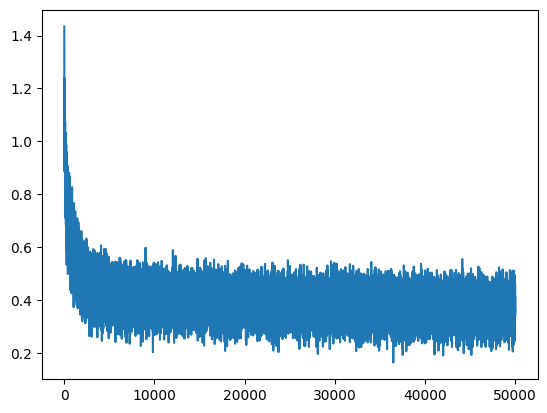

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# loss over the entire dataset, dev set for evaluation
emb = C[Xdev] # only index those rows that have been chosen for the mini batch, (32,3,2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss) # full sense of how the model is performing

# one probable reason why the model is not performing too well could be that our embedding is 2-dimensional

tensor(2.2016, grad_fn=<NllLossBackward0>)


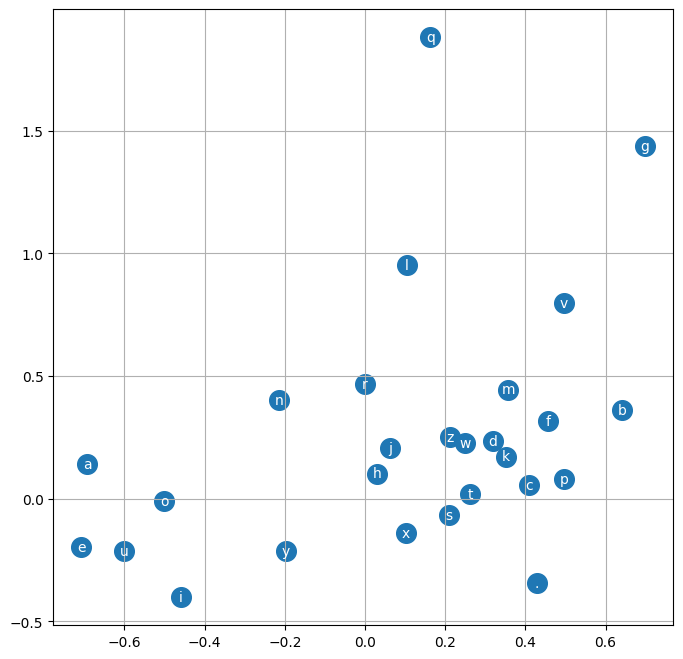

In [ ]:
# visualizing the embeddings learned by the network. right now, we have 2-dimensional embeddings so it's easy to visualize
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

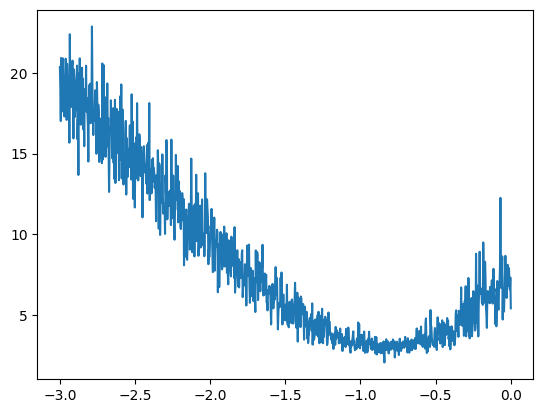

In [ ]:
plt.plot(lri, lossi)

In [ ]:
# below code was only for educational reasons and is highly inefficient as new tensors are created
#   counts = logits.exp()
#   prob = counts / counts.sum(1, keepdim = True)
#   loss = -prob[torch.arange(32), Y].log().mean()

# moreover, manually handling exp() can cause us to overflow and encounter situations where values are inf or nan

logits = torch.tensor([-500, -3, 0, 500])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [ ]:
# for very large positive numbers in our logits, we get nan because exp becomes infinite
# pytorch solves this internally for us, especially the cross entropy function by offsetting the values

# with exp, negative values are fine, since they become close to 0. for very large positive values, pytorch finds the highest value in the tensor, and offsets each value by that
# since we care only about probability, it doesn't matter
logits = torch.tensor([-500, -3, 0, 500]) - 500
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., 1.])

In [ ]:
# what we're doing right now is overfitting a very small batch and getting low loss
# too many parameters for too few inputs

In [ ]:
logits.max(1)

torch.return_types.max(
values=tensor([12.9837, 16.7995, 20.1492, 19.9484, 16.0426, 12.9837, 15.3000, 13.6362,
        15.3570, 17.6298, 15.1746, 20.2089, 12.9837, 16.2662, 16.4220, 19.2717,
        12.9837, 15.7248, 14.3059, 16.2198, 17.9727, 15.1780, 10.1905, 10.0803,
        15.0652, 12.9837, 15.6679, 16.2866, 12.3106, 15.7375, 18.3005, 15.0868],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]))

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [ ]:
# we are not able to get the loss to 0 because the input data set has contradictory expecations
# for '...', we expect 'e' in "emma"
# for '...', we expect 'o' in "olivia"

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%
# if a model has a large number of parameters, it is pretty easy for it to memorize the input dataset

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])] # embed the current context (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim = 1)
    ix = torch.multinomial(probs, num_samples = 1, replacement=True, generator = g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

carmah.
amelle.
khiemri.
revick.
kanden.
jazonen.
dellynn.
kaeli.
nellara.
chaiiv.
kaleky.
dham.
jory.
quint.
shonne.
livani.
wanelo.
dearynix.
kaelynn.
deley.
